<a href="https://colab.research.google.com/github/LukeBarboza/AI-Codes/blob/Classification/Hands_On_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

#Curva de ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Classificação Multiclasse
from sklearn.svm import SVC # Define automaticamente entre OvO (One Vs One) ou OvR(One vs All The Rest)

#caso você queira explicitamente escolher entre um dos dois

#OvR One Versus All The Rest
from sklearn.multiclass import OneVsRestClassifier

#OvO One Versus One
from sklearn.multiclass import OneVsOneClassifier

#escalonamento das entradas
from sklearn.preprocessing import StandardScaler

#Classificação Multirótulo
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#Returning values from sklearn
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
#General Functions
def plot_digits(data, images_per_row=5):
    """Exibe imagens de dígitos manuscritos em uma grade."""
    data = data.reshape(-1, 28, 28)  # Garante que as imagens estão no formato correto
    rows = (len(data) - 1) // images_per_row + 1
    plt.figure(figsize=(images_per_row, rows))

    for i, image in enumerate(data):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis("off")  # Remove os eixos


In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

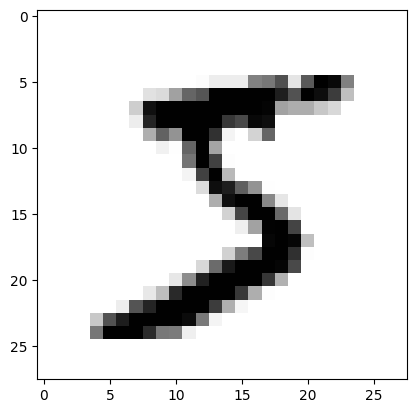

In [ ]:
#Looking at one algarism in dataset
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [ ]:
#Convertendo y para inteiro
y = y.astype(np.uint8)
y

,class
0,5
1,0
2,4
3,1
4,9
...,...
69995,2
69996,3
69997,4
69998,5


In [ ]:
#Dividindo em dados para treinamento e para teste
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
#Por enquanto, vamos apenas tentar identificar um número

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
#Treinando utilizando SGDClassifier para identificar o número 5 no MNIST

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
#Identificando o número 5
sgd_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [ ]:
#validating with cross_val_score that uses kfolds to validade, remenbering that this method splits the data in folds to train and test
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
#Class to generate non 5 numbers
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass

  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
#Testing model without any 5 number
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [ ]:
#Melhor forma para avaliar um classificador é a matriz de confusão.
#Isso contabiliza o número de vezes que as intâncias da classe A são classificadas como Classe B.

#Realizando validação
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
#Calculando matriz de confusão
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
#Pretending to have reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
#Calculando precisão
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
#Calculando revocação
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
#Calculando F-score que é a média harmonica da precisão e revocação

f1_score(y_train_5, y_train_pred)

#F1 score é favorecido quando revocação e precisão são parecidos.

#Você pode preferir alta precisão ou alta Revocação mas não se pode ter tudo isso se chama trade off


0.7325171197343847

In [ ]:
#Score de confiança
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [ ]:
threshold = 8000 #Aumentar  o limitar diminui a revocação, ou seja mais precisão.
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
#Usando cross_val_predict() para obter os scores e então definir qual limiar (Treshold) usar

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [ ]:
#Usando os y_scores gerados para calcular precisão e revocação
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
#Usando matplotlib para plotar a precisão e revocação

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))  # Define o tamanho da figura
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisão")  # Linha azul tracejada para precisão
    plt.plot(thresholds, recalls[:-1], "g-", label="Revocação")  # Linha verde sólida para recall

    # Adiciona rótulos dos eixos
    plt.xlabel("Threshold")
    plt.ylabel("Score")

    # Adiciona título ao gráfico
    plt.title("Precisão e Revocação vs Threshold")

    # Adiciona a grade para melhor visualização
    plt.grid(True, linestyle="--", alpha=0.6)

    # Adiciona a legenda
    plt.legend()

    # Mostra o gráfico
    plt.show()

In [ ]:
def plot_precision_recall_curve(y_true, y_scores):
    # Calculando as precisões e revocações para diferentes thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    # Plotando a curva de precisão-revocação
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label="Curva Precisão vs Revocação", color="b")

    # Adicionando rótulos e título
    plt.xlabel("Revocação")
    plt.ylabel("Precisão")
    plt.title("Curva de Precisão vs Revocação")

    # Adicionando a grade
    plt.grid(True, linestyle="--", alpha=0.6)

    # Adicionando a legenda
    plt.legend()

    # Exibindo o gráfico
    plt.show()

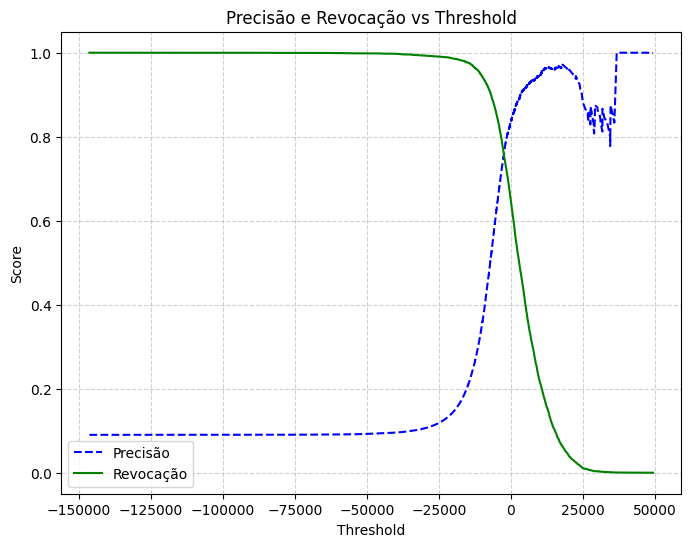

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

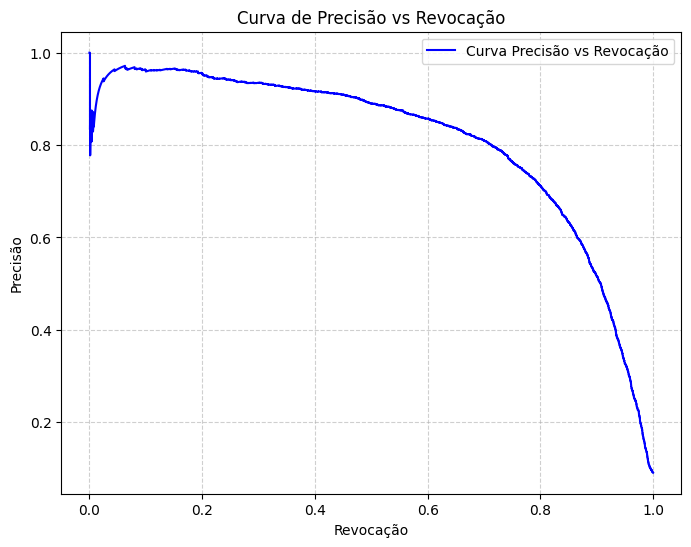

In [ ]:
plot_precision_recall_curve(y_train_5, y_scores)

In [ ]:
#Identificando o threshold para precisão de 90 por cento
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
#Calculando precisão
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
#Calculando revocação
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [ ]:
#Lembrese que um classificador de alta precisão não é muito util com uma revocação muito baixa como trade off
#Porque se ele tiver o recall muito baixo ele acaba sendo menos preciso

In [ ]:
#CURVA DE ROC ou COR (em portugues)
# É semelhante a curva de Precisão/Revocação mas ao invés disso representa a taxa de veradeiros positivos.

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal tracejada (linha de aleatoriedade)

    # Adicionando rótulos aos eixos
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')

    # Adicionando título
    plt.title('Curva ROC')

    # Adicionando grade
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adicionando a legenda
    if label:
        plt.legend()


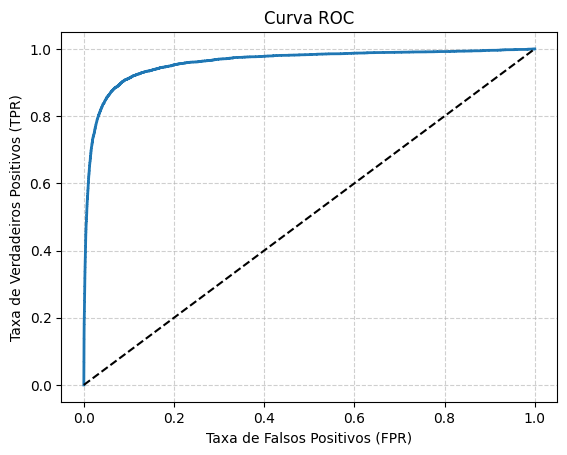

In [ ]:
plot_roc_curve(fpr, tpr)

In [ ]:
#Calculando AUC Área sob a Curva
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
#Utilizando Random Forest Classifier para uma comparação futura
forest_clf = RandomForestClassifier(random_state=42)

#Realizando treinamento com cross validation
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] #score=probabilidade de classe positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

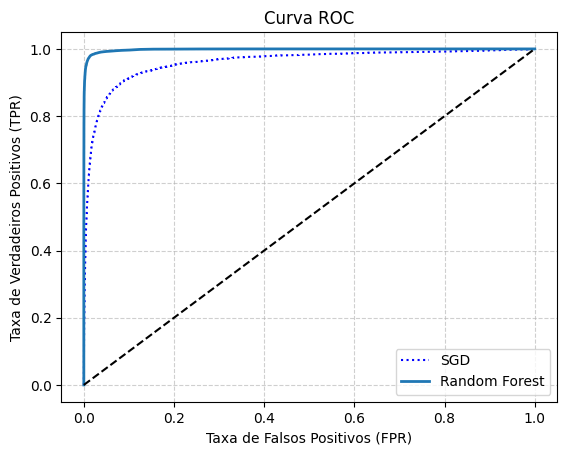

In [ ]:
#Plotando curva de ROC
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [ ]:
#Recalculando Revocação e Precisão com arvore

# Convertendo as probabilidades para previsões binárias (threshold = 0.5)
# Considerando que estamos interessados na classe positiva (índice 1)
y_tree_pred = (y_probas_forest[:, 1] >= 0.5).astype(int)

# Calculando a matriz de confusão
confusion_matrix(y_train_5, y_tree_pred)

array([[54530,    49],
       [  691,  4730]])

In [ ]:
#Calculando precisão
precision_score(y_train_5, y_tree_pred)

0.9897468089558485

In [ ]:
#Calculando revocação
recall_score(y_train_5, y_tree_pred)

0.8725327430363402

In [ ]:
#Calculando F-score que é a média harmonica da precisão e revocação

f1_score(y_train_5, y_tree_pred)

#F1 score é favorecido quando revocação e precisão são parecidos.

#Você pode preferir alta precisão ou alta Revocação mas não se pode ter tudo isso se chama trade off


0.9274509803921569

In [ ]:
#TREINAMENTO MULTICLASSE!!

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [ ]:
#Listando os Scores de cada categoria
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
#Categoria com maior Score
np.argmax(some_digit_scores)

5

In [ ]:
#Classes
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
#Classe 5
svm_clf.classes_[5]

5

In [ ]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [ ]:
#Acha que é 3 ao invés de 5
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [ ]:
# 4️⃣ Fazer uma previsão
some_digit_scaled = scaler.transform([some_digit])  # Escalar a entrada antes de prever
prediction = sgd_clf.predict(some_digit_scaled)
print("Previsão:", prediction)

Previsão: [5]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#Improving a model
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
#Mostrando matriz de confusão
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

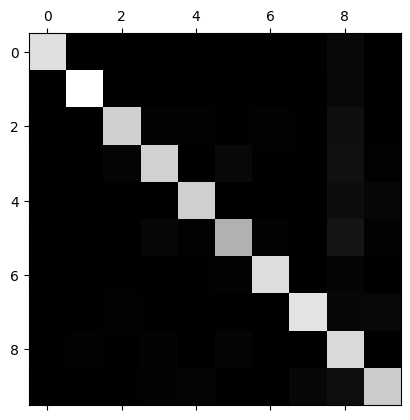

In [ ]:
#Parece que é um modelo muito bom, mas vamos checar os erros.
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

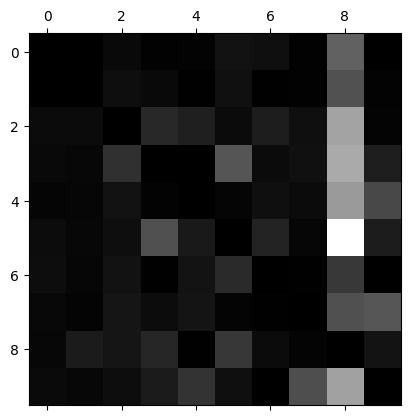

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

<Figure size 800x800 with 0 Axes>

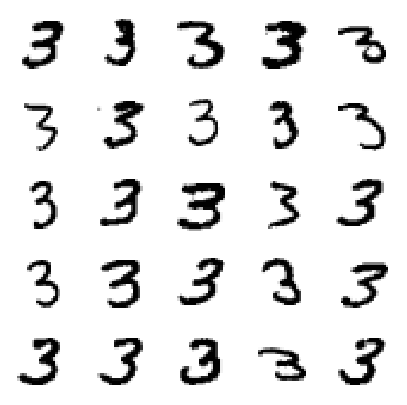

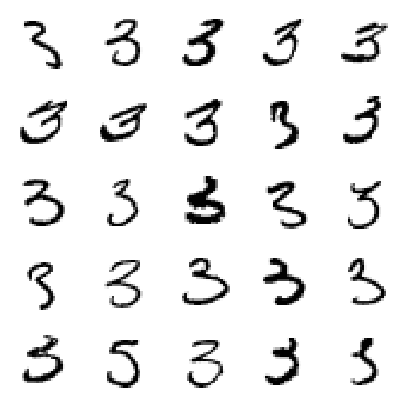

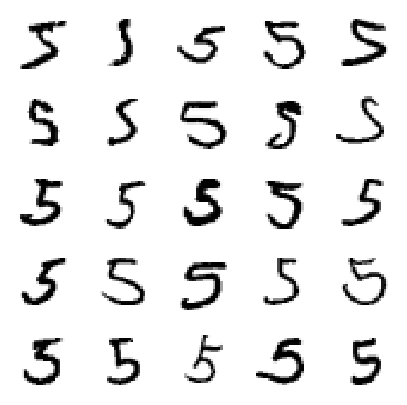

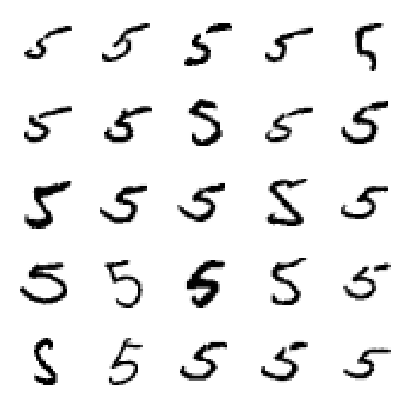

In [ ]:
#Plotando imagens dos numeros do MNIST
cl_a, cl_b, = 3, 5

# Converter os DataFrames para NumPy arrays
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)].to_numpy()
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)].to_numpy()
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)].to_numpy()
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)].to_numpy()

# Plotar os resultados
plt.figure(figsize=(8,8))
plot_digits(X_aa[:25])
plot_digits(X_ab[:25])
plot_digits(X_ba[:25])
plot_digits(X_bb[:25])

In [ ]:
#Classificação Multirrótulo
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [ ]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [ ]:
#Avaliando um classificador multirrótulo
#Calculando F1 para cada rótulo individual

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

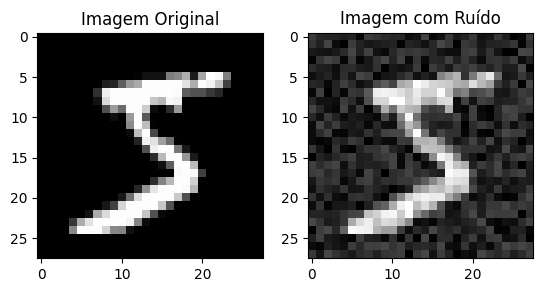

In [ ]:
#Classificação Multioutput
#Adicionando ruido a um rotulo no MNIST

# Se X_train for um DataFrame, converta para um array NumPy
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()

# Gerar o ruído e adicionar aos dados
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Modificar y_train e y_test (presumivelmente, você quer usar X_train como y_train)
y_train_mod = X_train
y_test_mod = X_test

# Visualizar a imagem com ruído
# Selecionando um índice para visualizar uma imagem
index = 0  # Você pode mudar o índice para visualizar diferentes imagens

# Usando iloc para acessar a linha
original_image = X_train.iloc[index].to_numpy() if isinstance(X_train, pd.DataFrame) else X_train[index]
noisy_image = X_train_mod[index]

# Plotando a imagem original
plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(28, 28), cmap='gray')
plt.title('Imagem Original')

# Plotando a imagem com ruído
plt.subplot(1, 2, 2)
plt.imshow(noisy_image.reshape(28, 28), cmap='gray')
plt.title('Imagem com Ruído')

plt.show()

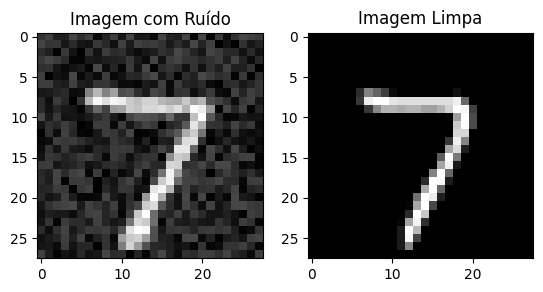

In [ ]:
#Treinando classificador para limpar a imagem

# Verifique se X_test_mod é um DataFrame, se for, converta para um array NumPy
if isinstance(X_test_mod, pd.DataFrame):
    X_test_mod = X_test_mod.to_numpy()

# Treinando o classificador
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_mod, y_train_mod)

# Fazendo a previsão para a imagem com ruído
clean_digit = knn_clf.predict([X_test_mod[0]])

# Visualizar o resultado
plt.subplot(1, 2, 1)
plt.imshow(X_test_mod[0].reshape(28, 28), cmap='gray')
plt.title('Imagem com Ruído')

plt.subplot(1, 2, 2)
plt.imshow(clean_digit[0].reshape(28, 28), cmap='gray')  # A imagem "limpa" predita
plt.title('Imagem Limpa')

plt.show()